In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

In [3]:
bank_churn = pd.read_csv('./Cleaned_Modelling.csv')
bank_churn

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction,days_since_last_transaction
0,1,2101,66,Male,0.0,self_employed,187.0,2,755,1458.71,...,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0,2023-05-21,321.0
1,5,2329,90,other,0.0,self_employed,1020.0,2,582,2291.91,...,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1,2023-08-06,244.0
2,6,1579,42,Male,2.0,self_employed,1494.0,3,388,927.72,...,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1,2023-11-03,155.0
3,7,1923,42,Female,0.0,self_employed,1096.0,2,1666,15202.20,...,13798.82,0.36,0.36,857.50,286.07,15719.44,15349.75,0,2023-11-01,157.0
4,8,2048,72,Male,0.0,retired,1020.0,1,1,7006.93,...,11232.37,0.64,0.64,1299.64,439.26,7076.06,7755.98,0,2023-09-24,195.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24403,30295,2398,42,Male,0.0,self_employed,146.0,2,286,7493.69,...,3515.03,0.51,90.10,1103.20,1183.04,7956.03,7431.36,0,2023-11-04,154.0
24404,30297,2325,10,Female,0.0,student,1020.0,2,1207,1076.43,...,2787.70,0.30,0.30,0.30,0.30,1076.43,1076.43,0,2023-10-22,167.0
24405,30298,1537,34,Female,0.0,self_employed,1046.0,2,223,3844.10,...,3865.55,1.71,2.29,901.00,1014.07,3738.54,3690.32,0,2023-12-17,111.0
24406,30299,2376,47,Male,0.0,salaried,1096.0,2,588,65511.97,...,21925.81,4666.84,3883.06,168.23,71.80,61078.50,57564.24,1,2023-12-31,97.0


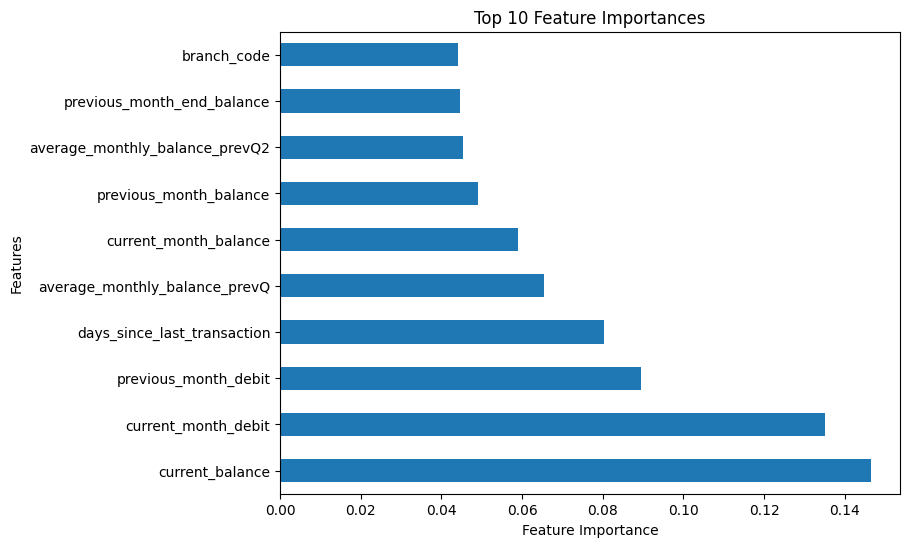

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the oversampling method
sm = SMOTE(random_state=42)

# Create your feature matrix X and target vector y
X = bank_churn.drop(columns=['churn', 'last_transaction', 'customer_id', 'gender', 'occupation'], axis=1)
y = bank_churn['churn']

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X)
X = pd.DataFrame(df_scaled, columns=X.columns)

X_res, y_res = sm.fit_resample(X,y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Apply oversampling ONLY ON the training data
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Get top 10 features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
importances = rf.feature_importances_

plt.figure(figsize=(8, 6))
feature_importances = pd.Series(rf.feature_importances_, index=X_train_res.columns).nlargest(10)
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.show()

In [5]:
most_important_features = list(feature_importances.index)
most_important_features

['current_balance',
 'current_month_debit',
 'previous_month_debit',
 'days_since_last_transaction',
 'average_monthly_balance_prevQ',
 'current_month_balance',
 'previous_month_balance',
 'average_monthly_balance_prevQ2',
 'previous_month_end_balance',
 'branch_code']

In [6]:
# Filter the dataset to include only the top 10 features
X_train_res = X_train_res[most_important_features]
X_test = X_test[most_important_features]

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X_train_res)
X_train_res = pd.DataFrame(df_scaled, columns = X_train_res.columns)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_res, y_train_res)

# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [30],
    'min_samples_split': [2],
}

# Define the StratifiedKFold object
cv = StratifiedKFold(n_splits=5)

# Create the GridSearchCV object. For scoring, use aucpr
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
rf = RandomForestClassifier(**best_params)
rf.fit(X_train_res, y_train_res)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Accuracy:  0.8223298496048942
Confusion Matrix: 
 [[3304  632]
 [ 762 3148]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.84      0.83      3936
           1       0.83      0.81      0.82      3910

    accuracy                           0.82      7846
   macro avg       0.82      0.82      0.82      7846
weighted avg       0.82      0.82      0.82      7846

F1 Score:  0.8187256176853055
ROC AUC Score:  0.8222729919115048


In [10]:
best_params

{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}

In [11]:
from sklearn.metrics import recall_score, precision_score

# Calculate specificity
specificity = recall_score(y_test, y_pred, pos_label=0)

# Calculate sensitivity
sensitivity = recall_score(y_test, y_pred, pos_label=1)

# Print the results
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


Specificity: 0.8394308943089431
Sensitivity: 0.8051150895140665


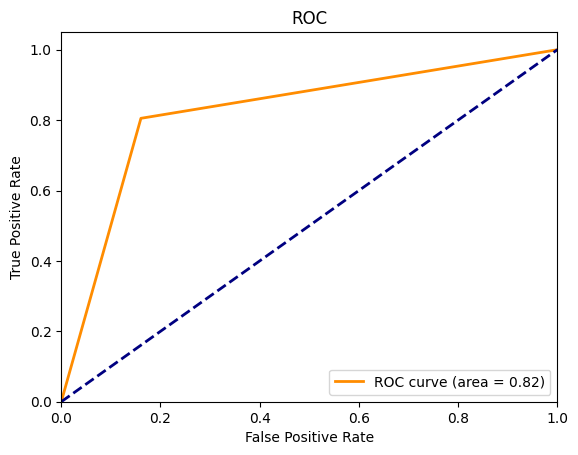

In [12]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Exporting to Pkl File
with open('model.pkl', 'wb') as f:
    pkl.dump(rf, f)


print("Model exported successfully to model.pkl")

Model exported successfully to model.pkl


**ADA Boosting**

In [26]:
#grid_search.fit(X_train_res, y_train_res)
#predict on X_test

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of weak learners
    'learning_rate': [0.1, 0.5, 1.0]         # Learning rate
}

# Initialize AdaBoost classifier with base estimator
base_estimator = DecisionTreeClassifier()
adaboost_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

In [29]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(adaboost_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best Score: 0.7382362304998409


In [30]:
# Evaluate the model with the best parameters
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7319653326535814


In [31]:
from sklearn.metrics import recall_score, precision_score

# Calculate specificity
specificity = recall_score(y_test, y_pred, pos_label=0)

# Calculate sensitivity
sensitivity = recall_score(y_test, y_pred, pos_label=1)

# Print the results
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


Specificity: 0.7390752032520326
Sensitivity: 0.7248081841432225


In [18]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Accuracy:  0.7319653326535814
Confusion Matrix: 
 [[2909 1027]
 [1076 2834]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.74      0.73      3936
           1       0.73      0.72      0.73      3910

    accuracy                           0.73      7846
   macro avg       0.73      0.73      0.73      7846
weighted avg       0.73      0.73      0.73      7846

F1 Score:  0.729378458370866
ROC AUC Score:  0.7319416936976274


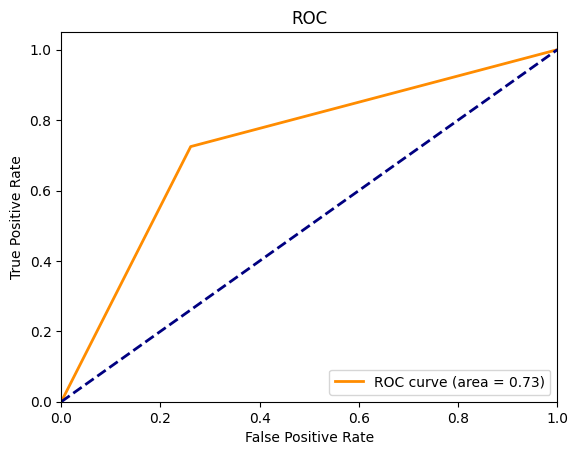

In [19]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Exporting to Pkl File
with open('ada_model.pkl', 'wb') as f:
    pkl.dump(adaboost_clf, f)


print("Model exported successfully to ada_model.pkl")

Model exported successfully to ada_model.pkl


**Logistic Regression**

In [21]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [22]:
# Step 4: Initialize logistic regression model
logistic_reg = LogisticRegression(max_iter=1000, random_state=42)

# Step 5: Fit the model to the training data
logistic_reg.fit(X_train_res, y_train_res)

# Step 6: Make predictions on the testing data
y_pred = logistic_reg.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5553148100943156


In [23]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Accuracy:  0.5553148100943156
Confusion Matrix: 
 [[1715 2221]
 [1268 2642]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.57      0.44      0.50      3936
           1       0.54      0.68      0.60      3910

    accuracy                           0.56      7846
   macro avg       0.56      0.56      0.55      7846
weighted avg       0.56      0.56      0.55      7846

F1 Score:  0.6023025190926706
ROC AUC Score:  0.5557124347618156


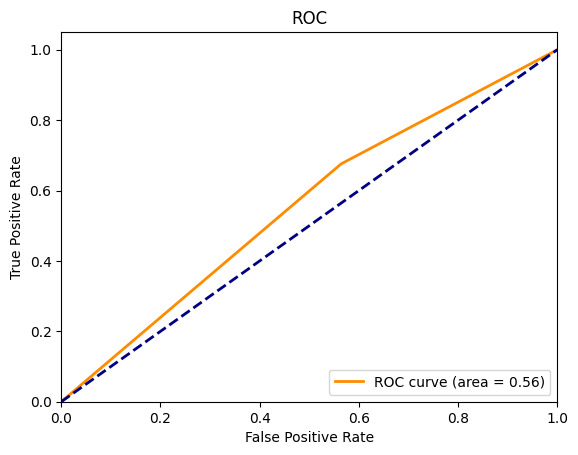

In [24]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [25]:
from sklearn.metrics import recall_score, precision_score

# Calculate specificity
specificity = recall_score(y_test, y_pred, pos_label=0)

# Calculate sensitivity
sensitivity = recall_score(y_test, y_pred, pos_label=1)

# Print the results
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


Specificity: 0.43572154471544716
Sensitivity: 0.6757033248081842


In [ ]:
# Exporting to Pkl File
with open('logistic_reg.pkl', 'wb') as f:
    pkl.dump(logistic_reg, f)


print("Model exported successfully to logistic_reg.pkl")

Model exported successfully to logistic_reg.pkl


**XG Boosting**

In [32]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [35]:
xg_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xg_model.fit(X_train_res, y_train_res)

# Step 4: Make predictions
y_pred = xg_model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8346928371144532


In [36]:
# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Accuracy:  0.8346928371144532
Confusion Matrix: 
 [[3410  526]
 [ 771 3139]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      3936
           1       0.86      0.80      0.83      3910

    accuracy                           0.83      7846
   macro avg       0.84      0.83      0.83      7846
weighted avg       0.84      0.83      0.83      7846

F1 Score:  0.8287788778877888
ROC AUC Score:  0.8345875439253114


In [37]:
from sklearn.metrics import recall_score, precision_score

# Calculate specificity
specificity = recall_score(y_test, y_pred, pos_label=0)

# Calculate sensitivity
sensitivity = recall_score(y_test, y_pred, pos_label=1)

# Print the results
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


Specificity: 0.8663617886178862
Sensitivity: 0.8028132992327366


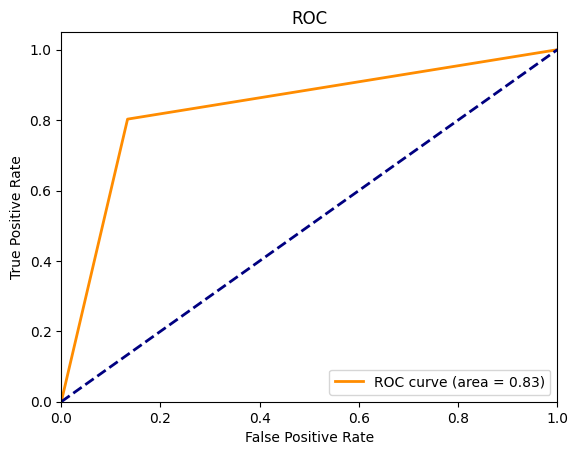

In [38]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Exporting to Pkl File
with open('xg_boost.pkl', 'wb') as f:
    pkl.dump(xg_model, f)


print("Model exported successfully to xg_boost.pkl")

Model exported successfully to xg_boost.pkl


In [ ]:
import pickle

# Load the model from file
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [ ]:
variable_labels = {
            'current_balance': 0.05,
            'current_month_debit': 0.05,
            'previous_month_debit': 0.05,
            'current_month_balance': 0.05,
            'average_monthly_balance_prevQ': 0.05,
            'previous_month_balance': 0.05,
            'previous_month_end_balance': 0.05,
            'average_monthly_balance_prevQ2': 0.05,
            'days_since_last_transaction': 0.05,
            'previous_month_credit': 0.05,
            'branch_code':20}

keys_important = ['current_balance','current_month_debit',
 'previous_month_debit',
 'days_since_last_transaction',
 'average_monthly_balance_prevQ',
 'current_month_balance',
 'previous_month_balance',
 'average_monthly_balance_prevQ2',
 'previous_month_end_balance',
 'branch_code']

values_important = [variable_labels[x] for x in keys_important]

In [ ]:
new_record = pd.DataFrame([values_important], columns=keys_important)

In [ ]:
loaded_model.predict(new_record)

array([1])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


def make_prediction(variable_labels):
  keys_important = ['current_balance','current_month_debit','previous_month_debit','days_since_last_transaction','average_monthly_balance_prevQ','current_month_balance','previous_month_balance','average_monthly_balance_prevQ2','previous_month_end_balance','branch_code']
  values_important = [variable_labels[x] for x in keys_important]
  new_record = pd.DataFrame([values_important], columns=keys_important)

  if loaded_model.predict(new_record) == 1:
    return "Customer has Churned"
  else:
    return "Customer has not Churned"

make_prediction(variable_labels)

'Customer has Churned'